## T5 Model Version and Tokenizer

In [1]:
from transformers import AutoTokenizer, T5ForConditionalGeneration

### Version

In [2]:
CKPT = 't5-base'

### Model and Tokenizer

In [3]:
model = T5ForConditionalGeneration.from_pretrained(CKPT)
tokenizer = AutoTokenizer.from_pretrained(CKPT)

c:\Users\Huang\anaconda3\envs\text2sql\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


## Data Loading and Preprocessing

In [4]:
from datasets import load_dataset

### Loading

In [5]:
train_data = load_dataset('spider', split='train')
test_data = load_dataset('spider', split='validation')

Found cached dataset spider (C:/Users/Huang/.cache/huggingface/datasets/spider/spider/1.0.0/4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa)
Found cached dataset spider (C:/Users/Huang/.cache/huggingface/datasets/spider/spider/1.0.0/4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa)


### Exploration

In [24]:
def format_eda_dataset(example):
    return {'input': example['question'], 'target': example['query']}
eda_dataset = train_data.map(format_eda_dataset, remove_columns=train_data.column_names)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [26]:
eda_dataset[1]

{'input': 'List the name, born state and age of the heads of departments ordered by age.',
 'target': 'SELECT name ,  born_state ,  age FROM head ORDER BY age'}

In [27]:
# map article and summary len to dict as well as if sample is longer than 512 tokens
def map_to_length(x):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('t5-base')
    x["input_len"] = len(tokenizer(x["input"]).input_ids)
    x["input_longer_256"] = int(x["input_len"] > 256)
    x["input_longer_128"] = int(x["input_len"] > 128)
    x["input_longer_64"] = int(x["input_len"] > 64)
    x["out_len"] = len(tokenizer(x["target"]).input_ids)
    x["out_longer_256"] = int(x["out_len"] > 256)
    x["out_longer_128"] = int(x["out_len"] > 128)
    x["out_longer_64"] = int(x["out_len"] > 64)
    return x

data_stats = eda_dataset.map(map_to_length, num_proc=4)


Map (num_proc=4):   0%|          | 0/7000 [00:00<?, ? examples/s]

In [28]:
sample_size = 7000

print(
    "Input Mean: {} \n%-Input > 256:{} \n%-Input > 128:{} \n%-Input > 64:{} \nOutput Mean:{} \n%-Output > 256:{} \n%-Output > 128:{} \n%-Output > 64:{}".format(
        sum(data_stats["input_len"]) / sample_size,
        sum(data_stats["input_longer_256"]) / sample_size,
        sum(data_stats["input_longer_128"]) / sample_size,
        sum(data_stats["input_longer_64"]) / sample_size,   
        sum(data_stats["out_len"]) / sample_size,
        sum(data_stats["out_longer_256"]) / sample_size,
        sum(data_stats["out_longer_128"]) / sample_size,
        sum(data_stats["out_longer_64"]) / sample_size,
    )
)

Input Mean: 16.610285714285713 
%-Input > 256:0.0 
%-Input > 128:0.0 
%-Input > 64:0.0 
Output Mean:43.751285714285714 
%-Output > 256:0.0 
%-Output > 128:0.012428571428571428 
%-Output > 64:0.21514285714285714


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

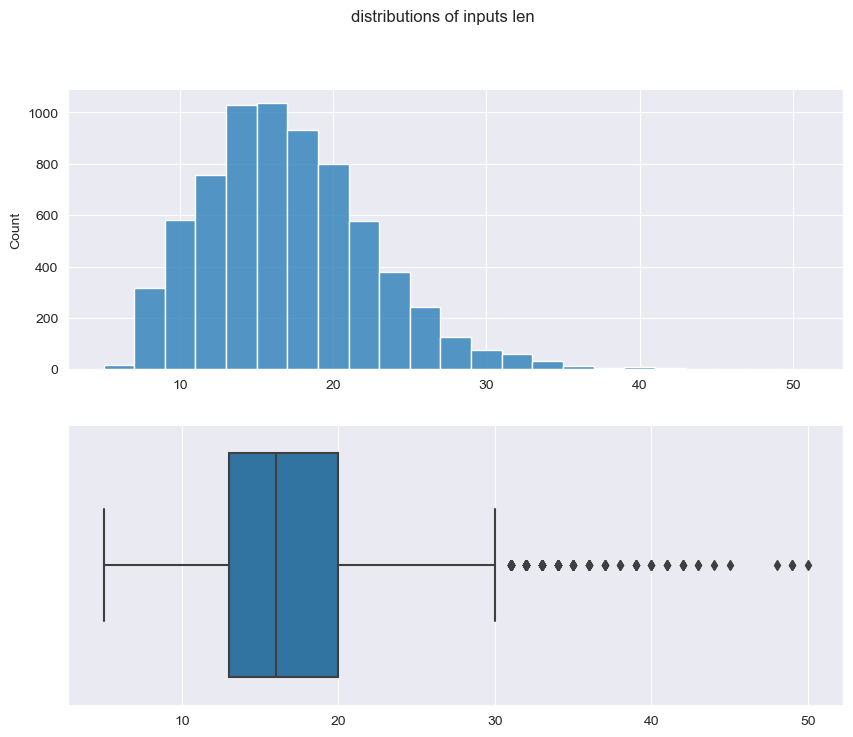

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8));
sns.histplot(x=data_stats["input_len"], ax=ax[0], binwidth=2);
sns.boxplot(x=data_stats["input_len"], ax=ax[1]);
fig.suptitle('distributions of inputs len');

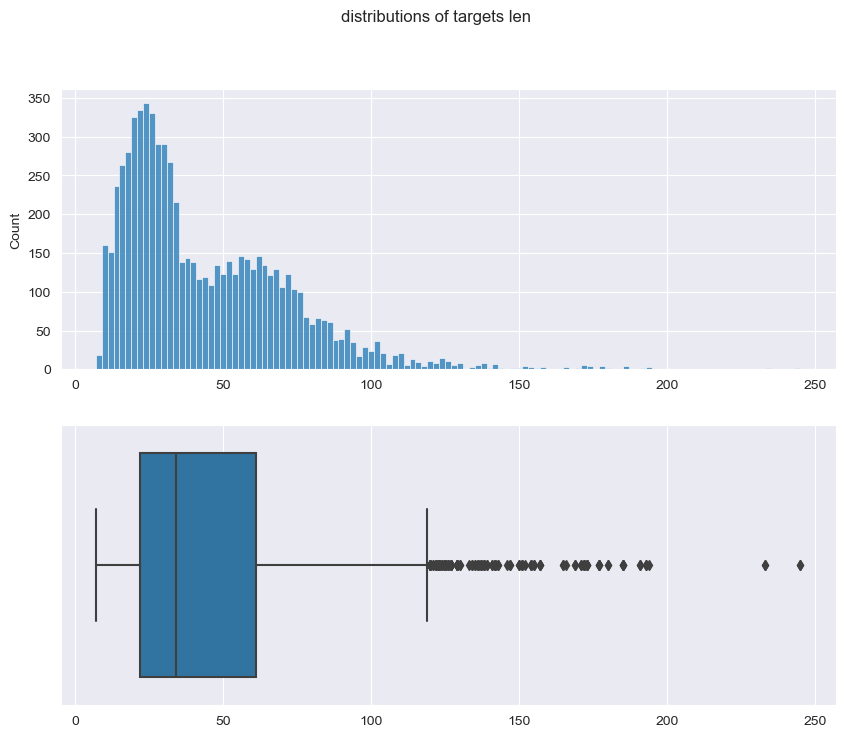

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8));
sns.histplot(x=data_stats["out_len"], ax=ax[0], binwidth=2);
sns.boxplot(x=data_stats["out_len"], ax=ax[1]);
fig.suptitle('distributions of targets len');

### Transformation

In [6]:
train_data

Dataset({
    features: ['db_id', 'query', 'question', 'query_toks', 'query_toks_no_value', 'question_toks'],
    num_rows: 7000
})

In [7]:
test_data

Dataset({
    features: ['db_id', 'query', 'question', 'query_toks', 'query_toks_no_value', 'question_toks'],
    num_rows: 1034
})

In [8]:
def format_dataset_spider(example):
    return {'input': 'translate to SQL: ' + example['question'], 'target': example['query']}

In [9]:
train_dataset = train_data.map(format_dataset_spider, remove_columns=train_data.column_names)
test_dataset = test_data.map(format_dataset_spider, remove_columns=test_data.column_names)

Loading cached processed dataset at C:\Users\Huang\.cache\huggingface\datasets\spider\spider\1.0.0\4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa\cache-2abc974a3b9e0520.arrow
Loading cached processed dataset at C:\Users\Huang\.cache\huggingface\datasets\spider\spider\1.0.0\4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa\cache-b0d15a568188cf44.arrow


In [10]:
train_dataset

Dataset({
    features: ['input', 'target'],
    num_rows: 7000
})

In [11]:
test_dataset

Dataset({
    features: ['input', 'target'],
    num_rows: 1034
})

### Tokenization

In [12]:
# tokenize the examples
def convert_to_features(example_batch):
    input_encodings = tokenizer.batch_encode_plus(example_batch['input'], pad_to_max_length=True, max_length=64)
    target_encodings = tokenizer.batch_encode_plus(example_batch['target'], pad_to_max_length=True, max_length=64)

    encodings = {
        'input_ids': input_encodings['input_ids'], 
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids'],
        'decoder_attention_mask': target_encodings['attention_mask']
    }

    return encodings

In [13]:
train_dataset = train_dataset.map(convert_to_features, batched=True, remove_columns=train_dataset.column_names)
test_dataset = test_dataset.map(convert_to_features, batched=True, remove_columns=test_dataset.column_names)

columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']

train_dataset.set_format(type='torch', columns=columns)
test_dataset.set_format(type='torch', columns=columns)

Loading cached processed dataset at C:\Users\Huang\.cache\huggingface\datasets\spider\spider\1.0.0\4e5143d825a3895451569c8b9b55432b91a4bc2d04d390376c950837f4680daa\cache-c6f3e8e231dec107.arrow


Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Huang\anaconda3\envs\text2sql\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Model Training

In [14]:
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

### Trainer Args

In [15]:
# set training arguments - Feel free to adapt it
training_args = Seq2SeqTrainingArguments(
    output_dir="t5_base_spider",
    per_device_train_batch_size=16,
    num_train_epochs=10,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=500,
    save_strategy="epoch",
    #save_steps=1000,
    #eval_steps=1000,
    overwrite_output_dir=True,
    save_total_limit=3,
    load_best_model_at_end=True,
    push_to_hub=False
    #fp16=True, 
)

### Metrics

In [16]:
from datasets import load_metric
rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

C:\Users\Huang\AppData\Local\Temp\ipykernel_8380\3190919124.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


### Trainer

In [17]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [18]:
trainer.train()

c:\Users\Huang\anaconda3\envs\text2sql\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7000
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4380
  Number of trainable parameters = 222903552


  0%|          | 0/4380 [00:00<?, ?it/s]

***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5749145746231079, 'eval_rouge2_precision': 0.4339, 'eval_rouge2_recall': 0.286, 'eval_rouge2_fmeasure': 0.3258, 'eval_runtime': 28.8488, 'eval_samples_per_second': 35.842, 'eval_steps_per_second': 2.253, 'epoch': 1.0}


Model weights saved in t5_base_spider\checkpoint-438\pytorch_model.bin


{'loss': 0.8853, 'learning_rate': 4.4292237442922375e-05, 'epoch': 1.14}


***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5337422490119934, 'eval_rouge2_precision': 0.468, 'eval_rouge2_recall': 0.3087, 'eval_rouge2_fmeasure': 0.3512, 'eval_runtime': 28.7792, 'eval_samples_per_second': 35.929, 'eval_steps_per_second': 2.259, 'epoch': 2.0}


Model weights saved in t5_base_spider\checkpoint-876\pytorch_model.bin


{'loss': 0.4113, 'learning_rate': 3.8584474885844754e-05, 'epoch': 2.28}


***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5317121744155884, 'eval_rouge2_precision': 0.4768, 'eval_rouge2_recall': 0.3131, 'eval_rouge2_fmeasure': 0.3575, 'eval_runtime': 27.7593, 'eval_samples_per_second': 37.249, 'eval_steps_per_second': 2.342, 'epoch': 3.0}


Model weights saved in t5_base_spider\checkpoint-1314\pytorch_model.bin


{'loss': 0.3271, 'learning_rate': 3.287671232876712e-05, 'epoch': 3.42}


***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5377039909362793, 'eval_rouge2_precision': 0.4984, 'eval_rouge2_recall': 0.3255, 'eval_rouge2_fmeasure': 0.3732, 'eval_runtime': 27.5042, 'eval_samples_per_second': 37.594, 'eval_steps_per_second': 2.363, 'epoch': 4.0}


Model weights saved in t5_base_spider\checkpoint-1752\pytorch_model.bin
Deleting older checkpoint [t5_base_spider\checkpoint-438] due to args.save_total_limit


{'loss': 0.2752, 'learning_rate': 2.71689497716895e-05, 'epoch': 4.57}


***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5394584536552429, 'eval_rouge2_precision': 0.4892, 'eval_rouge2_recall': 0.3168, 'eval_rouge2_fmeasure': 0.3637, 'eval_runtime': 29.9128, 'eval_samples_per_second': 34.567, 'eval_steps_per_second': 2.173, 'epoch': 5.0}


Model weights saved in t5_base_spider\checkpoint-2190\pytorch_model.bin
Deleting older checkpoint [t5_base_spider\checkpoint-876] due to args.save_total_limit


{'loss': 0.2468, 'learning_rate': 2.1461187214611872e-05, 'epoch': 5.71}


***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5512824654579163, 'eval_rouge2_precision': 0.5027, 'eval_rouge2_recall': 0.3307, 'eval_rouge2_fmeasure': 0.3781, 'eval_runtime': 29.523, 'eval_samples_per_second': 35.024, 'eval_steps_per_second': 2.202, 'epoch': 6.0}


Model weights saved in t5_base_spider\checkpoint-2628\pytorch_model.bin
Deleting older checkpoint [t5_base_spider\checkpoint-1752] due to args.save_total_limit


{'loss': 0.2251, 'learning_rate': 1.5753424657534248e-05, 'epoch': 6.85}


***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5535199046134949, 'eval_rouge2_precision': 0.491, 'eval_rouge2_recall': 0.3244, 'eval_rouge2_fmeasure': 0.3698, 'eval_runtime': 27.8543, 'eval_samples_per_second': 37.122, 'eval_steps_per_second': 2.334, 'epoch': 7.0}


Model weights saved in t5_base_spider\checkpoint-3066\pytorch_model.bin
Deleting older checkpoint [t5_base_spider\checkpoint-2190] due to args.save_total_limit


{'loss': 0.2094, 'learning_rate': 1.004566210045662e-05, 'epoch': 7.99}


***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5610367655754089, 'eval_rouge2_precision': 0.4951, 'eval_rouge2_recall': 0.3259, 'eval_rouge2_fmeasure': 0.3725, 'eval_runtime': 28.0334, 'eval_samples_per_second': 36.885, 'eval_steps_per_second': 2.319, 'epoch': 8.0}


Model weights saved in t5_base_spider\checkpoint-3504\pytorch_model.bin
Deleting older checkpoint [t5_base_spider\checkpoint-2628] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5621151924133301, 'eval_rouge2_precision': 0.4931, 'eval_rouge2_recall': 0.324, 'eval_rouge2_fmeasure': 0.3703, 'eval_runtime': 26.6993, 'eval_samples_per_second': 38.728, 'eval_steps_per_second': 2.435, 'epoch': 9.0}


Model weights saved in t5_base_spider\checkpoint-3942\pytorch_model.bin
Deleting older checkpoint [t5_base_spider\checkpoint-3066] due to args.save_total_limit


{'loss': 0.199, 'learning_rate': 4.337899543378996e-06, 'epoch': 9.13}


***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5642394423484802, 'eval_rouge2_precision': 0.491, 'eval_rouge2_recall': 0.3233, 'eval_rouge2_fmeasure': 0.3697, 'eval_runtime': 32.8118, 'eval_samples_per_second': 31.513, 'eval_steps_per_second': 1.981, 'epoch': 10.0}


Model weights saved in t5_base_spider\checkpoint-4380\pytorch_model.bin
Deleting older checkpoint [t5_base_spider\checkpoint-3504] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from t5_base_spider\checkpoint-1314 (score: 0.5317121744155884).


{'train_runtime': 1489.0442, 'train_samples_per_second': 47.01, 'train_steps_per_second': 2.941, 'train_loss': 0.3342209262934994, 'epoch': 10.0}


TrainOutput(global_step=4380, training_loss=0.3342209262934994, metrics={'train_runtime': 1489.0442, 'train_samples_per_second': 47.01, 'train_steps_per_second': 2.941, 'train_loss': 0.3342209262934994, 'epoch': 10.0})

In [21]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1034
  Batch size = 16
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



  0%|          | 0/65 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 0.5317121744155884,
 'eval_rouge2_precision': 0.4768,
 'eval_rouge2_recall': 0.3131,
 'eval_rouge2_fmeasure': 0.3575,
 'eval_runtime': 31.1984,
 'eval_samples_per_second': 33.143,
 'eval_steps_per_second': 2.083,
 'epoch': 10.0}

In [19]:
trainer.save_model()

Saving model checkpoint to t5_base_spider
Configuration saved in t5_base_spider\config.json
Configuration saved in t5_base_spider\generation_config.json
Model weights saved in t5_base_spider\pytorch_model.bin


In [20]:
tokenizer.save_pretrained('t5_base_spider')

tokenizer config file saved in t5_base_spider\tokenizer_config.json
Special tokens file saved in t5_base_spider\special_tokens_map.json
Copy vocab file to t5_base_spider\spiece.model


('t5_base_spider\\tokenizer_config.json',
 't5_base_spider\\special_tokens_map.json',
 't5_base_spider\\spiece.model',
 't5_base_spider\\added_tokens.json',
 't5_base_spider\\tokenizer.json')

## Model Inference on WikiSQL Test Set

### Fine Tuned Model

In [24]:
CKPT = 't5_base_finetuned_wikisql'
model_tuned = T5ForConditionalGeneration.from_pretrained(CKPT)
tokenizer_tuned = AutoTokenizer.from_pretrained(CKPT)

loading configuration file t5_base_finetuned_wikisql\config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "ea

### Inference Set

In [26]:
inference_data = load_dataset('wikisql', split='test')

In [29]:
def translate_to_sql(text, tokenizer, model):
    inputs = tokenizer(text, padding='longest', max_length=64, return_tensors='pt')
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    output = model.generate(input_ids, attention_mask=attention_mask, max_length=64)

    return tokenizer.decode(output[0], skip_special_tokens=True)

In [30]:
for i in range(0,100,10):
    print('translate to SQL: ' + inference_data[i]['question'])
    print('Predict. :' + translate_to_sql('translate to SQL: ' + inference_data[i]['question'], tokenizer=tokenizer_tuned, model=model_tuned))
    print('Expected: ' + inference_data[i]['sql']['human_readable'])
    print('=================================\n')
     

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



translate to SQL: What is terrence ross' nationality


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT Nationality FROM table WHERE Player = Terrence Ross
Expected: SELECT Nationality FROM table WHERE Player = Terrence Ross

translate to SQL: How many different nationalities do the players of New Jersey Devils come from?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT COUNT Nationality FROM table WHERE NHL team = New Jersey Devils
Expected: SELECT COUNT Nationality FROM table WHERE NHL team = New Jersey Devils

translate to SQL: If you are a pilot officer in the commonwealth then what will you called as in the US air force?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT US Air Force FROM table WHERE Position = Pilot Officer AND Country = Commonwealth
Expected: SELECT US Air Force equivalent FROM table WHERE Commonwealth equivalent = Pilot Officer

translate to SQL: what is the total number of total w–l where doubles w–l is 11–11


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT COUNT Total W–L FROM table WHERE Doubles W–L = 11–11
Expected: SELECT COUNT Total W–L FROM table WHERE Doubles W–L = 11–11

translate to SQL: Which Frequency is used for WEGP calls?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT Frequency FROM table WHERE Caller ID = wepg
Expected: SELECT Frequency FROM table WHERE Calls = WEGP

translate to SQL: If a radius is 10, what  is the lowest possible mass?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT MIN Mass FROM table WHERE Radius = 10
Expected: SELECT MIN Mass (M ☉ ) FROM table WHERE Radius (R ☉ ) = 10

translate to SQL: what's the new south wales with crop (kilotonnes) being canola


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT New South Wales FROM table WHERE Crop (kilotonnes) = Canola
Expected: SELECT New South Wales FROM table WHERE Crop (kilotonnes) = Canola

translate to SQL: If % lunsford is 51.82% what is the % mcconnell in Letcher?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT Letcher FROM table WHERE % Lunsford = 51.82%
Expected: SELECT % McConnell FROM table WHERE % Lunsford = 51.82%

translate to SQL: What is the percentage of the Shivalik Zone where the percentage of the Mid-Hill Zone is 10%?


Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Predict. :SELECT Shivalik Zone FROM table WHERE Mid-Hill Zone = 10%
Expected: SELECT Shivalik Zone FROM table WHERE Mid-Hill Zone = 10%

translate to SQL: How many episodes in season 6 titles "Poppin' Tags"?
Predict. :SELECT COUNT No. in season FROM table WHERE Title = "Poppin' Tags"
Expected: SELECT COUNT No. in season FROM table WHERE Title = "Poppin' Tags"



## Model Inference on CoSQL